In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
import time
import sys

# Inputting the Data

In [2]:
# method
alphas = np.linspace(0.1,.9,10)
beta = 1
filesScore = ["Pij_2009.csv","Pij_2010.csv",
              "Pij_2011.csv","Pij_2012.csv",
              "Pij_2013.csv","Pij_2014.csv",
              "Pij_2015.csv","Pij_2016.csv",
              "Pij_2017.csv","Pij_2018.csv"]

filesPercs = ["2009_win_perc.csv","2010_win_perc.csv","2011_win_perc.csv","2012_win_perc.csv",
             "2013_win_perc.csv","2014_win_perc.csv","2015_win_perc.csv",
             "2016_win_perc.csv","2017_win_perc.csv","2018_win_perc.csv"]
namesCols = ["win_perc_2009","win_perc_2010","win_perc_2011","win_perc_2012",
            "win_perc_2013","win_perc_2014","win_perc_2015",
            "win_perc_2016","win_perc_2017","win_perc_2018"]

# Function that Takes the Output of the Rankings and Determines The Percent Correct

In [3]:
def ranking_analyzer(output,names,plot = False, threshold = 0):
    # importing necessary libraries
    from itertools import combinations
    # getting vectors from the data frame
    perc1 = np.array(output[names[0]])
    perc2 = np.array(output[names[1]])
    percscore = np.array(output['score'])
    # getting the combinations
    combs = list(combinations(np.arange(32), 2))
    ncombs = len(combs)
    # initiailizing the vectors
    scorediff = np.zeros(int(ncombs))
    wins1diff = np.zeros(int(ncombs))
    wins2diff = np.zeros(int(ncombs))
    # Computing the values
    for counter, pairs in enumerate(combs):
        scorediff[counter] = percscore[pairs[0]] - percscore[pairs[1]]
        wins1diff[counter] = perc1[pairs[0]] - perc1[pairs[1]]
        wins2diff[counter] = perc2[pairs[0]] - perc2[pairs[1]]

    # putting in a mask for plotting perspective
    mask = wins1diff < 0/16
    scorediff_not_adv = scorediff[mask]
    scorediff_adv = scorediff[np.invert(mask)]

    wins2diff_not_adv = wins2diff[mask]
    wins2diff_adv = wins2diff[np.invert(mask)]
    if plot == True:
        threshmask = scorediff_not_adv > threshold
        scoreplt = scorediff_not_adv[threshmask]
        winsplt = wins2diff_not_adv[threshmask]
        
        correctmask = winsplt > 0
        xc = scoreplt[correctmask]
        yc = winsplt[correctmask]
        xic = scoreplt[np.invert(correctmask)]
        yic = winsplt[np.invert(correctmask)]
        
        plt.figure(figsize=(15,7))
        plt.plot(scorediff_not_adv,wins2diff_not_adv,'ko',label = "Predictions Outside of Threshold")
        plt.plot(xc,yc,'go',label = "Correct Contrary Prediction")
        plt.plot(xic,yic,'ro',label = "Incorrect Contrary Prediction")
        plt.plot([0,1.01*np.max(scorediff)],[0,0],'k-')
        plt.plot([threshold,threshold],[np.min(wins2diff),np.max(wins2diff)],'k-')
        plt.xlabel('Difference in PageRank Score')
        plt.ylabel('Difference in Following Year Winning Percentage')
        plt.legend()
        plt.grid()
        
    
    # Getting the percentage of games where a team with a same or worse record in year N
    # with a better PageRank ended up being better in year N+1
    # Threshold determines amount PageRank needs to be better by
    
    mask = scorediff_not_adv > threshold
    wins2diff_not_adv = wins2diff_not_adv[mask]
    perc_upset = np.sum(wins2diff_not_adv > 0)/len(wins2diff_not_adv)
    n_upset_opps = len(wins2diff_not_adv)
    
    if plot == True:
        plt.title("Correct Percentage of Contrary Predictions: %.3f" %perc_upset)
    
    
    # Getting the total combinations right
    perc_correct_score = sum(wins2diff>0)/len(scorediff)
    perc_correct_wins = (sum(np.logical_and(wins1diff>0,wins2diff>0))+ \
                         sum(np.logical_and(wins1diff<0,wins2diff<0)))/len(wins1diff)
    
    return perc_upset, perc_correct_score,perc_correct_wins,n_upset_opps
    

# Function to Take A Pij Matrix and Apply Bagging

We want this function to take as an inputs:

- $P_{ij}$, the original stochastic matrix.
- $\alpha$, the teleportation paramter
- $stats1$, a vector containing the winning percentages of the teams of interest
- $namesCols$, the names of the win percentage vectors
- $N$, the number of teams to eliminate at each step (anticipate 1 or 2 will be best)
- $method$, the method for determining $\nu$, set to 0 (for using weights in each node) by default if not specified.


We want this function to output:

- $S$, a matrix of scores where each row is one of the 32 teams, and each column is that teams computed score when ommiting a combination of teams

In [4]:
def score_bagging(Pij, stats1, namesCols, alpha, N, Nsims = 2500, method = 0):
    
    if N == 0:
        Pij_group = Pij
        teamnum = np.arange(32)
        if method == 0:
            # making the teleporting probabilities uniform
            v = np.ones(len(teamnum)-N)/(len(teamnum)-N)
            v = v[np.newaxis]
            v = v.T
            # Setting alpha
            alpha = alpha
            # Setting eT
            eT = np.ones(len(teamnum)-N)[np.newaxis]   
        else:
            # making the teleporting probabilities proportional to
            # the teams winning percentages
            v = np.array(stats1[namesCols])
            v = np.delete(v, group)
            v = v[np.newaxis]
            v = v.T
            v = v/np.sum(v)
            # Setting alpha
            alpha = alpha
            # Setting eT
            eT = np.ones(len(teamnum)-N)[np.newaxis]
                
        # initializing our first guess
        x0 = np.ones(len(teamnum)-N)/len(teamnum)-N
        x0 = x0[np.newaxis]
        x0 = x0.T
            
        # performing the simulation (so our scores are stored in x0)
        for i in range(Nsims):
            x0 = alpha*np.dot(Pij_group,x0) + (1-alpha)*v
        return x0
        
    
    # setting a vector to contain each of the 32 team numbers
    teamnum = np.arange(32)
    # Getting the possible combinations of this to use
    combs = list(combinations(teamnum, N))
    ncombs = len(combs)
    # initializing a matrix to store each of these values
    scores = np.zeros((len(teamnum),ncombs))
    # We iterate over all of these combinations, each time computing a final score vector
    for counter, group in enumerate(combs):
        # Adjusting Pij (first deleting the specified rows, then columns)
        Pij_group = np.delete(Pij,group,axis = 0)
        Pij_group = np.delete(Pij_group,group,axis = 1)
        
        # Ensuring Pij has no zero columns
        if len(np.where(Pij_group.sum(axis = 0) == 0)[0]) > 0:
                empty_vect = np.where(Pij_group.sum(axis = 0) == 0)[0]
                for iCnt in range(len(empty_vect)):
                    Pij_group[empty_vect[iCnt],empty_vect[iCnt]] = 1
        
        # -----------Getting the Scores (FROM PREVIOUS CODE)------------------------
        # If we want the teleportation probabilties unifrom,
        # or based on team winning perc
        if method == 0:
            # making the teleporting probabilities uniform
            v = np.ones(len(teamnum)-N)/(len(teamnum)-N)
            v = v[np.newaxis]
            v = v.T
            # Setting alpha
            alpha = alpha
            # Setting eT
            eT = np.ones(len(teamnum)-N)[np.newaxis]   
        else:
            # making the teleporting probabilities proportional to
            # the teams winning percentages
            v = np.array(stats1[namesCols])
            v = np.delete(v, group)
            v = v[np.newaxis]
            v = v.T
            v = v/np.sum(v)
            # Setting alpha
            alpha = alpha
            # Setting eT
            eT = np.ones(len(teamnum)-N)[np.newaxis]
                
        # initializing our first guess
        x0 = np.ones(len(teamnum)-N)/len(teamnum)-N
        x0 = x0[np.newaxis]
        x0 = x0.T
            
        # performing the simulation (so our scores are stored in x0)
        for i in range(Nsims):
            x0 = alpha*np.dot(Pij_group,x0) + (1-alpha)*v

        # ---------------------- (END OF PREVIOUS CODE) ------------------------
        # getting a vector of the values of the teams computed
        kept_vect = np.delete(teamnum,group)
        # Updating the matrix
        scores[kept_vect,counter] = np.squeeze(x0)
    return scores    

# Function to take the Score Matrix as an Input and Output the Final PageRank Vector

This function takes as inputs:

- $S$, a matrix of scores where each row is one of the 32 teams, and each column is that teams computed score when ommiting a combination of teams
- $\bar{x}$, the PageRank vector computed for each team over __full__ data set.
- $\beta$, where the PageRank for each team is computed to be $x_i = (1-\beta)\bar{x}_i + \beta\big(min\{S_{ik}, 1 \leq k \leq {32 \choose N} \text{ for } k \in Z \}\big)$ where $N$ is the number of games removed at a time from the "score_bagging" function.

This function outputs:

- $x$, the vector containing the final PageRank scores for each team.

In [5]:
def final_score(S, x_bar, beta):
    # getting the minimum vector
    min_vect = np.zeros(32)
    # computing the minimums
    for iCnt in range(len(min_vect)):
        # accounting for winless teams
        if len(S[iCnt,np.nonzero(S[iCnt,])[0]]) == 0:
            min_vect[iCnt] = 0
        else:
            min_vect[iCnt] =  np.min(S[iCnt,np.nonzero(S[iCnt,])[0]])
    # normalizing the minimum vector
    min_vect = min_vect/np.sum(min_vect)
    # computing x
    x = (1-beta)*x_bar + beta*min_vect
    # normalizing x
    x = x/np.sum(x)
    # returning the value
    return np.squeeze(x)

# Writing a Function to Take Alpha As a Parameter and Compute the Percent of Correct Combinations

This function has the following inputs:

- $\beta$, where the PageRank for each team is computed to be $x_i = (1-\beta)\bar{x}_i + \beta\big(min\{S_{ik}, 1 \leq k \leq {32 \choose N} \text{ for } k \in Z \}\big)$ where $N$ is the number of games removed at a time from the "score_bagging" function.
- $\alpha$, the teleportation parameter
- $method$, the method for determining $\nu$, set to 0 (for using weights in each node) by default if not specified.
- $filesScore$, vector of filenames containing the socres in proper matrix form
- $filesPercs$, a vector of filenames containing the winning percentages of each team in a given year (used for $\nu$ non-uniform)
- $namesCols$, the names of the win percentage vectors
- $N$, the number of teams to omit on each iteration
- $nSims$, the number of terms to include in the approximation of the true eigenvector
- $weighted$, a boolean value that is true if the nodes of the graph are to be weighted, and false if they are to be binary.

This function has the following outputs:

- __score_perc_total__, the percentage of combinations of teams correctly predicted by the bagged PageRank method
- __score_perc_S2__, the standard error of the percentage of combinations of teams correctly predicted by the bagged PageRank method
- __wins_perc_total__, the percentage of combinations of teams correctly predicted by the standings in the current year
- __wins_perc_S2__, the standard error of the percentage of combinations of teams correctly predicted by the standings in the current year

In [6]:
def alpha_optimize_perc_combs(alphas,beta,method,filesScore,filesPercs,namesCols, N = 1, nSims = 4000,weighted = True):
    # intializing two vectors to store results
    score_perc_total = np.zeros(len(alphas))
    score_perc_S2 = np.zeros(len(alphas))
    wins_perc_total = np.zeros(len(alphas))
    wins_perc_S2 = np.zeros(len(alphas))

    indexer = 0
    
    # iterating over all alphas
    
    # making a waitbar
    toolbar_width = len(alphas)
    sys.stdout.write("[%s]" % (" " * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1))

    
    for alpha_try in alphas:
        
        if(alpha_try >= .8):
            nSims_use = nSims
        else:
            nSims_use = 2500
        
        # initializing the two correlations
        mc_perc_score = 0
        mc_perc_wins = 0
        
        # intializing a vector to get each percentage (for getting a standard deviation)
        sd_vect = np.zeros(len(filesScore) - 1)
        sd_vect_wins = np.zeros(len(filesScore) - 1)
        
        # iterating over all years (we lose a year since we don't have anything 
        # to regress the 2019 data on)
        for year_of_data in np.arange(len(filesScore) - 1):
            
            # reading in the data
            data = pd.read_csv(filesScore[year_of_data],index_col=0)
            stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
            stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
            # converting to a numpy array
            data2 = np.array(data)
            
            if(weighted == False):
                data2[data2!=0] = 1
            
            # making the Pij matrix
            Pij = data2/data2.sum(axis=0)
            
            # If we want the teleportation probabilties unifrom,
            # or based on team winning perc
            if method == 0:
                # making the teleporting probabilities uniform
                v = np.ones(32)/32
                v = v[np.newaxis]
                v = v.T
                # Setting eT
                eT = np.ones(32)[np.newaxis]   
            else:
                # making the teleporting probabilities proportional to
                # the teams winning percentages
                v = np.array(stats1[namesCols[year_of_data]])
                v = v[np.newaxis]
                v = v.T
                v = v/np.sum(v)
                # Setting eT
                eT = np.ones(32)[np.newaxis]
                
            # initializing our first guess
            x0 = np.ones(32)/32
            x0 = x0[np.newaxis]
            x0 = x0.T
            
            # performing the simulation
            for i in range(nSims_use):
                x0 = alpha_try*np.dot(Pij,x0) + (1-alpha_try)*v
            
            x0 = np.squeeze(x0)
                
            # ---------------------- NEW PART OF FUNCTION (ADAPTING x0 to xf) ---------------
            
            scores_mat = score_bagging(Pij, stats1, namesCols[year_of_data], \
                                       alpha_try, N, Nsims = nSims_use, method = method)
            
            xf = final_score(scores_mat, x0, beta)
            
            # -------------------------------------------------------------------------------

            # defining the team names
            team_names = np.array(data.columns.get_values())
            
            # ordering the team's by their score
            mask = np.argsort(np.squeeze(xf))[::-1]
            xf_df = np.squeeze(xf[mask])
            team_names_df = team_names[mask]
            
            # forming a data frame
            teamrank = {'Team': team_names_df, 'score': xf_df, 'wins': 32*16/2*xf_df}
            teamrank_df = pd.DataFrame(data=teamrank)
            
            output = pd.merge(teamrank_df,
                  stats1,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")

            output = pd.merge(output,
                  stats2,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")
            
            # Figuring out ranks
            names = [namesCols[year_of_data],namesCols[year_of_data+1]]
            pu, ps, pw, opps = ranking_analyzer(output,names)
            
            # Storing the results
            mc_perc_score += ps
            sd_vect[year_of_data] = ps
            mc_perc_wins += pw
            sd_vect_wins[year_of_data] = pw
            
            
            
        # Updating the percentages
        score_perc_total[indexer] = mc_perc_score/(len(filesScore) - 1)
        score_perc_S2[indexer] = np.std(sd_vect)/np.sqrt(len(filesScore) - 1)
        wins_perc_total[indexer] = mc_perc_wins/(len(filesScore) - 1)
        wins_perc_S2[indexer] = np.std(sd_vect_wins)/np.sqrt(len(filesScore) - 1)
        indexer += 1
        sys.stdout.write("-")
        sys.stdout.flush()
    
        
    sys.stdout.write("\n")
    return score_perc_total,score_perc_S2,wins_perc_total,wins_perc_S2

# Cross Validation

In [13]:
def alpha_optimize_perc_combs_CV(alphas,beta,method,filesScore,filesPercs,namesCols, N = 1, nSims = 4000,weighted = True):
    
    score_perc_CV = 0
    
    # Getting only the values we want
    
    for CV_val in range(len(filesScore)-1):
        
        # intializing two vectors to store results
        score_perc_total = np.zeros(len(alphas))
        score_perc_S2 = np.zeros(len(alphas))
        wins_perc_total = np.zeros(len(alphas))
        wins_perc_S2 = np.zeros(len(alphas))

        indexer = 0
        
        # making a waitbar
        toolbar_width = len(alphas)
        sys.stdout.write("[%s]" % (" " * toolbar_width))
        sys.stdout.flush()
        sys.stdout.write("\b" * (toolbar_width+1))

        # iterating over all alphas
        for alpha_try in alphas:

            if(alpha_try >= .8):
                nSims_use = nSims
            else:
                nSims_use = 5000

            # initializing the two correlations
            mc_perc_score = 0
            mc_perc_wins = 0

            # intializing a vector to get each percentage (for getting a standard deviation)
            sd_vect = np.zeros(len(filesScore) - 1)
            sd_vect_wins = np.zeros(len(filesScore) - 1)

            # iterating over all years (we lose a year since we don't have anything 
            # to regress the 2019 data on)
            range_vals = np.arange(len(filesScore) - 1)
            range_vals_2 = np.append(range_vals[0:CV_val],range_vals[CV_val+1:])
            
            for year_of_data in range_vals_2[:-1]:

                # reading in the data
                data = pd.read_csv(filesScore[year_of_data],index_col=0)
                stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
                stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
                # converting to a numpy array
                data2 = np.array(data)

                if(weighted == False):
                    data2[data2!=0] = 1

                # making the Pij matrix
                Pij = data2/data2.sum(axis=0)

                # If we want the teleportation probabilties unifrom,
                # or based on team winning perc
                if method == 0:
                    # making the teleporting probabilities uniform
                    v = np.ones(32)/32
                    v = v[np.newaxis]
                    v = v.T
                    # Setting eT
                    eT = np.ones(32)[np.newaxis]   
                else:
                    # making the teleporting probabilities proportional to
                    # the teams winning percentages
                    v = np.array(stats1[namesCols[year_of_data]])
                    v = v[np.newaxis]
                    v = v.T
                    v = v/np.sum(v)
                    # Setting eT
                    eT = np.ones(32)[np.newaxis]

                # initializing our first guess
                x0 = np.ones(32)/32
                x0 = x0[np.newaxis]
                x0 = x0.T

                # performing the simulation
                for i in range(nSims_use):
                    x0 = alpha_try*np.dot(Pij,x0) + (1-alpha_try)*v

                x0 = np.squeeze(x0)

                # ---------------------- NEW PART OF FUNCTION (ADAPTING x0 to xf) ---------------

                scores_mat = score_bagging(Pij, stats1, namesCols[year_of_data], \
                                           alpha_try, N, Nsims = nSims_use, method = method)

                xf = final_score(scores_mat, x0, beta)

                # -------------------------------------------------------------------------------

                # defining the team names
                team_names = np.array(data.columns.get_values())

                # ordering the team's by their score
                mask = np.argsort(np.squeeze(xf))[::-1]
                xf_df = np.squeeze(xf[mask])
                team_names_df = team_names[mask]

                # forming a data frame
                teamrank = {'Team': team_names_df, 'score': xf_df, 'wins': 32*16/2*xf_df}
                teamrank_df = pd.DataFrame(data=teamrank)

                output = pd.merge(teamrank_df,
                      stats1,
                      left_on = "Team",
                      right_on = "team",
                      how = "inner")

                output = pd.merge(output,
                      stats2,
                      left_on = "Team",
                      right_on = "team",
                      how = "inner")

                # Figuring out ranks
                names = [namesCols[year_of_data],namesCols[year_of_data+1]]
                pu, ps, pw, opps = ranking_analyzer(output,names)

                # Storing the results
                mc_perc_score += ps
                sd_vect[year_of_data] = ps
                mc_perc_wins += pw
                sd_vect_wins[year_of_data] = pw

            # Updating the percentages
            score_perc_total[indexer] = mc_perc_score/(len(filesScore) - 1)
            score_perc_S2[indexer] = np.std(sd_vect)/np.sqrt(len(filesScore) - 1)
            wins_perc_total[indexer] = mc_perc_wins/(len(filesScore) - 1)
            wins_perc_S2[indexer] = np.std(sd_vect_wins)/np.sqrt(len(filesScore) - 1)
            indexer += 1
            
            sys.stdout.write("-")
            sys.stdout.flush()
            
        # recording the best value of alpha
        alpha_best = alphas[np.argmax(score_perc_total)]
        
        # TESTING THAT VALUE OF ALPHA ON THE LEFT OUT YEAR OF DATA
        
        for year_of_data in [CV_val]:

                # reading in the data
                data = pd.read_csv(filesScore[year_of_data],index_col=0)
                stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
                stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
                # converting to a numpy array
                data2 = np.array(data)

                if(weighted == False):
                    data2[data2!=0] = 1

                # making the Pij matrix
                Pij = data2/data2.sum(axis=0)

                # If we want the teleportation probabilties unifrom,
                # or based on team winning perc
                if method == 0:
                    # making the teleporting probabilities uniform
                    v = np.ones(32)/32
                    v = v[np.newaxis]
                    v = v.T
                    # Setting eT
                    eT = np.ones(32)[np.newaxis]   
                else:
                    # making the teleporting probabilities proportional to
                    # the teams winning percentages
                    v = np.array(stats1[namesCols[year_of_data]])
                    v = v[np.newaxis]
                    v = v.T
                    v = v/np.sum(v)
                    # Setting eT
                    eT = np.ones(32)[np.newaxis]

                # initializing our first guess
                x0 = np.ones(32)/32
                x0 = x0[np.newaxis]
                x0 = x0.T

                # performing the simulation
                for i in range(nSims_use):
                    x0 = alpha_try*np.dot(Pij,x0) + (1-alpha_try)*v

                x0 = np.squeeze(x0)

                # ---------------------- NEW PART OF FUNCTION (ADAPTING x0 to xf) ---------------

                scores_mat = score_bagging(Pij, stats1, namesCols[year_of_data], \
                                           alpha_try, N, Nsims = nSims_use, method = method)

                xf = final_score(scores_mat, x0, beta)

                # -------------------------------------------------------------------------------

                # defining the team names
                team_names = np.array(data.columns.get_values())

                # ordering the team's by their score
                mask = np.argsort(np.squeeze(xf))[::-1]
                xf_df = np.squeeze(xf[mask])
                team_names_df = team_names[mask]

                # forming a data frame
                teamrank = {'Team': team_names_df, 'score': xf_df, 'wins': 32*16/2*xf_df}
                teamrank_df = pd.DataFrame(data=teamrank)

                output = pd.merge(teamrank_df,
                      stats1,
                      left_on = "Team",
                      right_on = "team",
                      how = "inner")

                output = pd.merge(output,
                      stats2,
                      left_on = "Team",
                      right_on = "team",
                      how = "inner")

                # Figuring out ranks
                names = [namesCols[year_of_data],namesCols[year_of_data+1]]
                pu, ps, pw, opps = ranking_analyzer(output,names)

                # Storing the results
                score_perc_CV += ps
        
    sys.stdout.write("\n")
    return score_perc_CV/(len(filesScore)-1)    
        
    

# Running it With N = 1, Beta = 1

In [10]:
sp1, ss1, wp1, ws1 = alpha_optimize_perc_combs(alphas,beta,0,filesScore, \
                                              filesPercs,namesCols, N = 1, weighted = False)

[          ----------


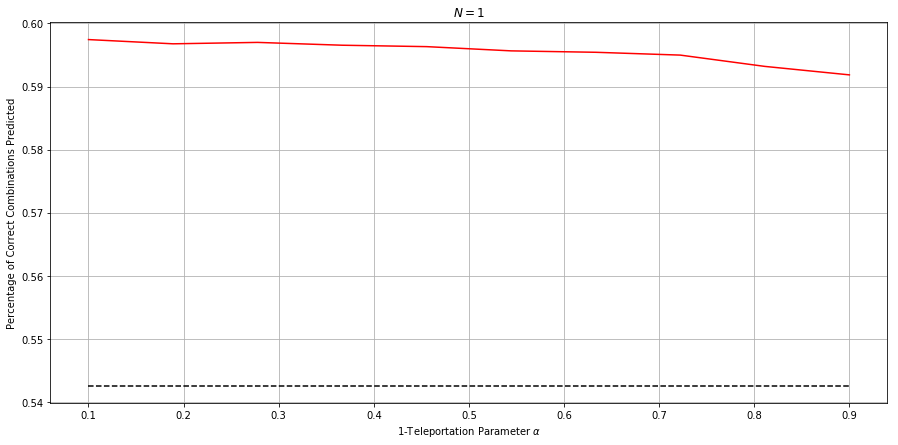

In [21]:
plt.figure(figsize=(15,7))
plt.plot(alphas, sp1, 'r-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 1$')
plt.plot(alphas, wp1, 'k--', label = r"Wins in Year $N$")
plt.grid()
plt.xlabel(r'1-Teleportation Parameter $\alpha$')
plt.ylabel("Percentage of Correct Combinations Predicted")
plt.legend()
plt.title(r'$N = 1$')
plt.show()

# Running it With N = 2, Beta = 1

In [25]:
alphas = np.linspace(0.2,0.6,20)

In [26]:
sp2, ss2, wp2, ws2 = alpha_optimize_perc_combs(alphas,beta,0,filesScore, \
                                              filesPercs,namesCols, N = 2, weighted = False)

[                    --------------------


In [14]:
alphas = np.linspace(0.3,.7,8)

In [15]:
SPCV = alpha_optimize_perc_combs_CV(alphas,beta,0,filesScore, \
                                              filesPercs,namesCols, N = 2, weighted = False)

[        --------[        --------[        --------[        --------[        --------[        --------[        --------[        --------[        --------


In [16]:
print(SPCV)

0.59811827957


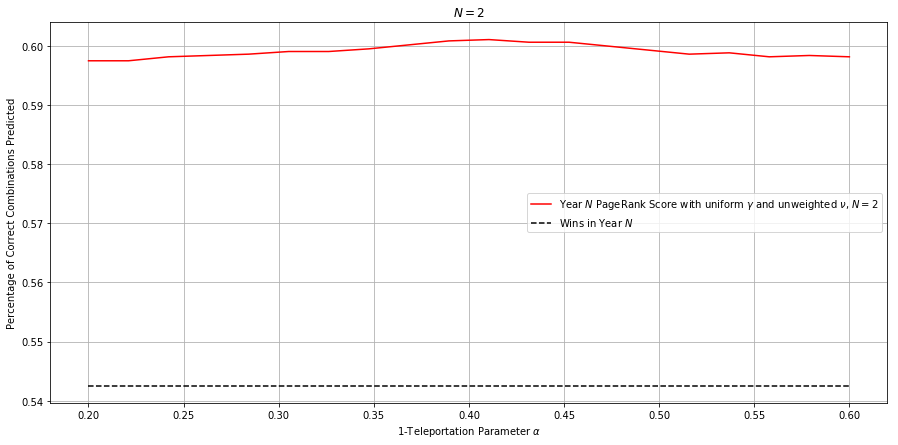

In [27]:
plt.figure(figsize=(15,7))
plt.plot(alphas, sp2, 'r-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 2$')
plt.plot(alphas, wp2, 'k--', label = r"Wins in Year $N$")
plt.grid()
plt.xlabel(r'1-Teleportation Parameter $\alpha$')
plt.ylabel("Percentage of Correct Combinations Predicted")
plt.title(r'$N = 2$')
plt.legend()
plt.show()

# Getting the Unchanged Percentages

In [38]:
alphas = np.linspace(0.1,.9,10)
sp4, ss4, wp4, ws4 = alpha_optimize_perc_combs(alphas,beta,0,filesScore, \
                                              filesPercs,namesCols, N = 0, weighted = False)

[          ----------


In [37]:
alphas = np.linspace(0.2,0.6,20)
sp3, ss3, wp3, ws3 = alpha_optimize_perc_combs(alphas,beta,0,filesScore, \
                                              filesPercs,namesCols, N = 0, weighted = False)

[                    --------------------


## Plotting up the Data

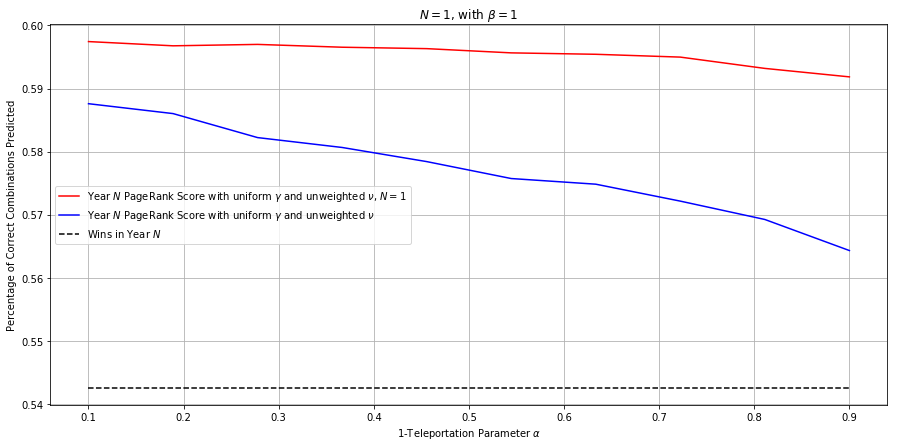

In [53]:
alphas = np.linspace(0.1,.9,10)
plt.figure(figsize=(15,7))
plt.plot(alphas, sp1, 'r-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 1$')
plt.plot(alphas, sp4, 'b-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$')
plt.plot(alphas, wp1, 'k--', label = r"Wins in Year $N$")
plt.grid()
plt.xlabel(r'1-Teleportation Parameter $\alpha$')
plt.ylabel("Percentage of Correct Combinations Predicted")
plt.title(r'$N = 1$, with $\beta = 1$')
plt.legend()
plt.show()

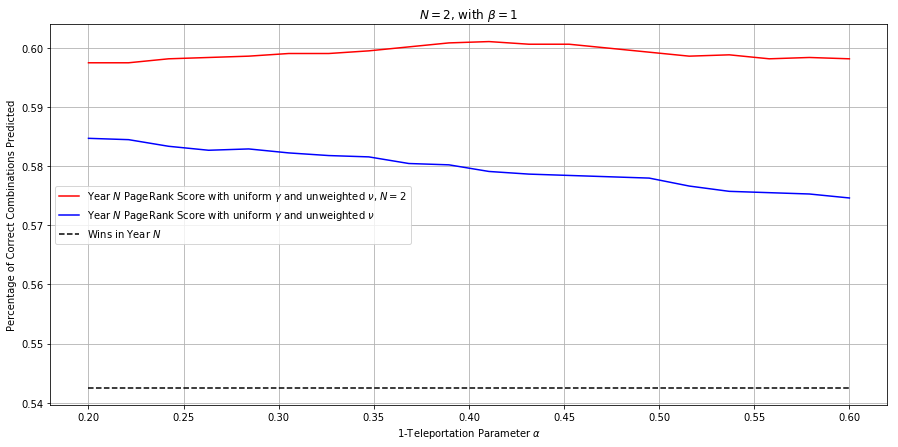

In [44]:
alphas = np.linspace(0.2,0.6,20)
plt.figure(figsize=(15,7))
plt.plot(alphas, sp2, 'r-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 2$')
plt.plot(alphas, sp3, 'b-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$')
plt.plot(alphas, wp2, 'k--', label = r"Wins in Year $N$")
plt.grid()
plt.xlabel(r'1-Teleportation Parameter $\alpha$')
plt.ylabel("Percentage of Correct Combinations Predicted")
plt.title(r'$N = 2$, with $\beta = 1$')
plt.legend()
plt.show()

In [47]:
alphas = np.linspace(0.2,0.6,20)
sp5, ss5, wp5, ws5 = alpha_optimize_perc_combs(alphas,beta,0,filesScore, \
                                              filesPercs,namesCols, N = 1, weighted = False)

[                    --------------------


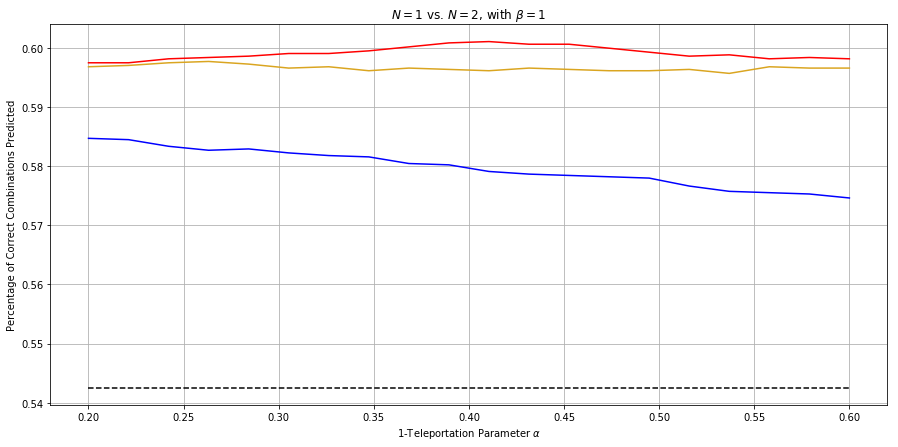

In [54]:
alphas = np.linspace(0.2,0.6,20)
plt.figure(figsize=(15,7))
plt.plot(alphas, sp2, 'r-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 2$', color = "red")
plt.plot(alphas, sp5, 'r-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 1$', color = "goldenrod")
plt.plot(alphas, sp3, 'b-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$')
plt.plot(alphas, wp2, 'k--', label = r"Wins in Year $N$")
plt.grid()
plt.xlabel(r'1-Teleportation Parameter $\alpha$')
plt.ylabel("Percentage of Correct Combinations Predicted")
plt.title(r'$N = 1$ vs. $N = 2$, with $\beta = 1$')

plt.show()

In [76]:
np.max(sp2)

0.60103046594982079

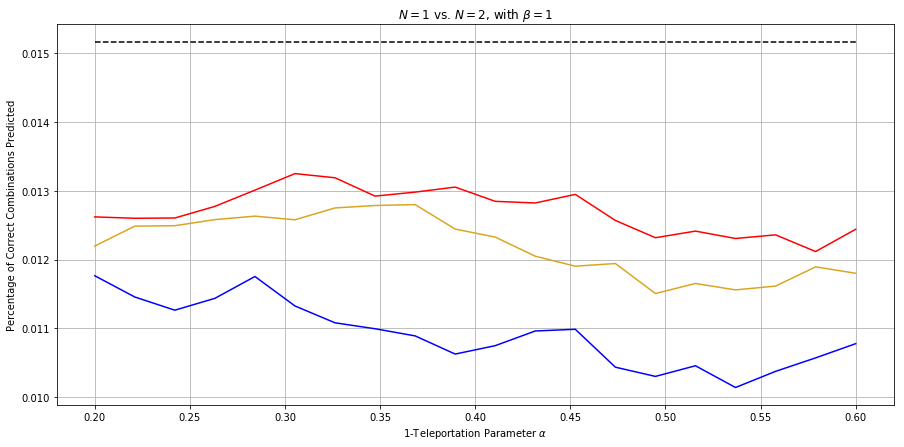

In [55]:
alphas = np.linspace(0.2,0.6,20)
plt.figure(figsize=(15,7))
plt.plot(alphas, ss2, 'r-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 2$', color = "red")
plt.plot(alphas, ss5, 'r-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 1$', color = "goldenrod")
plt.plot(alphas, ss3, 'b-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$')
plt.plot(alphas, ws2, 'k--', label = r"Wins in Year $N$")
plt.grid()
plt.xlabel(r'1-Teleportation Parameter $\alpha$')
plt.ylabel("Percentage of Correct Combinations Predicted")
plt.title(r'$N = 1$ vs. $N = 2$, with $\beta = 1$')
plt.show()

/Users/James/Desktop/Eigth Semester/Stochastic Modelling/NFL_Project


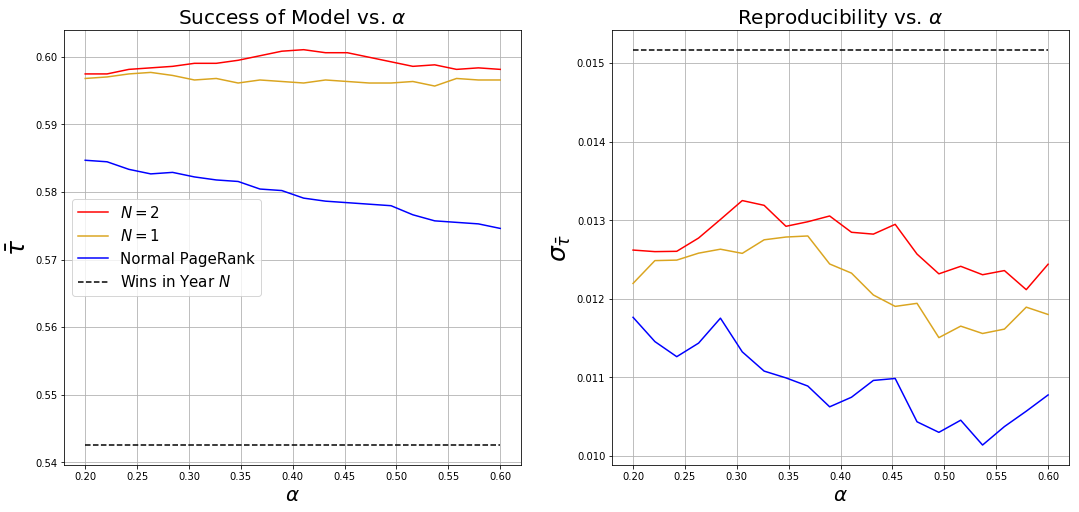

In [80]:
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(alphas, sp2, 'r-', label = r'$N = 2$', color = "red")
plt.plot(alphas, sp5, 'r-', label = r'$N = 1$', color = "goldenrod")
plt.plot(alphas, sp3, 'b-', label = r'Normal PageRank')
plt.plot(alphas, wp2, 'k--', label = r"Wins in Year $N$")
plt.grid()
plt.xlabel(r'$\alpha$',fontsize=20)
plt.ylabel(r'$\bar{\tau}$', fontsize=25)
plt.title(r'Success of Model vs. $\alpha$',fontsize=20)

plt.legend(prop={'size': 15})
plt.show

plt.subplot(1,2, 2)
plt.plot(alphas, ss2, 'r-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 2$', color = "red")
plt.plot(alphas, ss5, 'r-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$, $N = 1$', color = "goldenrod")
plt.plot(alphas, ss3, 'b-', label = r'Year $N$ PageRank Score with uniform $\gamma$ and unweighted $\nu$')
plt.plot(alphas, ws2, 'k--', label = r"Wins in Year $N$")
plt.grid()
plt.xlabel(r'$\alpha$',fontsize=20)
plt.ylabel(r'$\sigma_{\bar{\tau}}$', fontsize=25)
plt.title(r'Reproducibility vs. $\alpha$',fontsize=20)
%cd /Users/James/Desktop/Eigth Semester/Stochastic Modelling/NFL_Project/
plt.savefig('variancefix.png')
plt.show()
